In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow import keras

When we work with data for deep learning applications, we often have a massive amount of data, such that not all of it can fit in RAM. Therefore, we need to load the data into RAM in chunks. TensorFlow takes care of this for us, and we learn how here. Furthermore, we need to preprocess the data, such as normalizing it so that gradient descent methods will work. But there is not only numerical data to be preprocessed; we also have categorical data--such as words. We can preprocess categorical data into one-hot-vectors or *embeddings* (i.e., dense vectors that are learned from the categorical data, which represents the vectors).

# The Data API:
Our first stop is the data API. The central object that is dealt with by the data API is datasets, unsurprisingly.
https://www.tensorflow.org/api_docs/python/tf/data/Dataset

In [128]:
dataset = tf.data.Dataset.from_tensor_slices(tf.Variable(range(10), dtype='float32'))
dataset

<TensorSliceDataset shapes: (), types: tf.float32>

In [129]:
for i in dataset:
    print(i)

tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(2.0, shape=(), dtype=float32)
tf.Tensor(3.0, shape=(), dtype=float32)
tf.Tensor(4.0, shape=(), dtype=float32)
tf.Tensor(5.0, shape=(), dtype=float32)
tf.Tensor(6.0, shape=(), dtype=float32)
tf.Tensor(7.0, shape=(), dtype=float32)
tf.Tensor(8.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)


In [131]:
lol = dataset.repeat(12).shuffle(120).batch(18)
for i in lol:
    print(i)
print()

lol = dataset.repeat(12).shuffle(120).batch(18, drop_remainder=True)
for i in lol:
    print(i)

tf.Tensor([3. 6. 2. 8. 6. 1. 0. 5. 9. 3. 0. 6. 7. 1. 1. 8. 4. 9.], shape=(18,), dtype=float32)
tf.Tensor([1. 8. 9. 5. 1. 0. 0. 9. 8. 5. 9. 3. 4. 1. 3. 6. 0. 1.], shape=(18,), dtype=float32)
tf.Tensor([2. 6. 5. 2. 4. 8. 7. 9. 8. 6. 4. 0. 5. 0. 7. 0. 5. 7.], shape=(18,), dtype=float32)
tf.Tensor([6. 0. 0. 7. 3. 4. 7. 6. 5. 4. 4. 6. 2. 8. 8. 9. 4. 1.], shape=(18,), dtype=float32)
tf.Tensor([7. 2. 7. 7. 3. 6. 2. 6. 4. 3. 8. 5. 8. 2. 2. 9. 7. 3.], shape=(18,), dtype=float32)
tf.Tensor([5. 1. 9. 1. 7. 2. 6. 9. 8. 3. 3. 5. 5. 7. 4. 1. 3. 2.], shape=(18,), dtype=float32)
tf.Tensor([5. 9. 0. 4. 4. 0. 1. 2. 8. 9. 2. 3.], shape=(12,), dtype=float32)

tf.Tensor([0. 6. 8. 1. 2. 2. 0. 4. 0. 1. 9. 3. 1. 8. 3. 0. 9. 6.], shape=(18,), dtype=float32)
tf.Tensor([5. 7. 2. 3. 4. 0. 3. 8. 5. 5. 0. 7. 5. 1. 4. 8. 0. 6.], shape=(18,), dtype=float32)
tf.Tensor([9. 2. 3. 4. 1. 6. 0. 5. 6. 9. 8. 1. 4. 2. 8. 4. 9. 5.], shape=(18,), dtype=float32)
tf.Tensor([2. 4. 9. 1. 4. 1. 4. 6. 8. 3. 8. 9. 1. 2. 0. 0. 7. 7.], 

In [132]:
dataset = dataset.batch(len(dataset))

In [133]:
dataset = dataset.map(lambda x: x**2)

In [134]:
for i in dataset: print(i)

tf.Tensor([ 0.  1.  4.  9. 16. 25. 36. 49. 64. 81.], shape=(10,), dtype=float32)


In [135]:
mean = sum(j for j in i for i in dataset)
mean = tf.cast(mean, dtype='float32')
mean = mean / 10

In [136]:
# Normalizing the dataset
sums = sum((j - mean)**2 for j in i for i in dataset)
sums = tf.cast(sums, dtype='float32')
std_dev = tf.sqrt(1/(10 - 1) * sums)

dataset = dataset.map(lambda x: (x - mean)/std_dev)

In [137]:
for i in dataset: print(i)

tf.Tensor(
[-1.0068933  -0.97156364 -0.8655749  -0.68892694 -0.44161984 -0.12365355
  0.2649719   0.7242565   1.2542003   1.8548033 ], shape=(10,), dtype=float32)


In [145]:
points = np.array([i for i in dataset])

In [146]:
points = points[0]

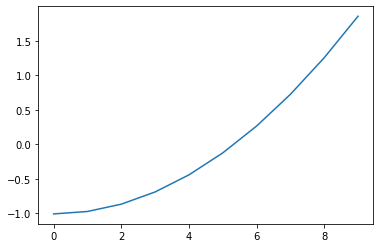

In [148]:
plt.plot(points)

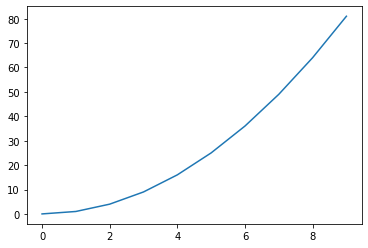

In [150]:
plt.plot([x**2 for x in range(10)])

#### Shuffling:
For performing gradient descent, it is important that our data is independent and identically distributed (IID). If not, the model will learn spurious structure from the data. Thus, if we do not have too much data, we can achieve IID by using the shuffle function from TensorFlow. The shuffle function requires us to specify how much items it will shuffle at each iteration. This is the buffer_size argument. So, for example, if the buffer_size is set to 14, then the first fourteen items will be selected from the dataset. Then, once some data is taken out of the buffer for training (or whatever), a random datum will be returned from the buffer and the buffer will grab a random datum from the dataset. This continues until the entire dataset has been iterated over. The max possible buffer size is determined by how much RAM we have at our disposal. Therefore, if we have a very large dataset and not enough RAM, shuffling may not suffice. This is because the buffer won't be able to hold onto enough data to ensure IID, and so spurious patterns in the data may be learned by chance of the buffer holding onto spuriously patterned data.

The solution to this is to shuffle the entire dataset by putting the dataset into separate files that are small enough to be shuffled multiple times and then randomly selection from which file you draw data from. However, TensorFlow implements this solution, so doing this is rather easy with TensorFLow.

In [152]:
# Shuffling example:
nums = tf.data.Dataset.from_tensor_slices(tf.Variable(range(10), dtype='float32'))

In [171]:
nums = nums.shuffle(2)
for i in nums: print(i)

tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(5.0, shape=(), dtype=float32)
tf.Tensor(4.0, shape=(), dtype=float32)
tf.Tensor(6.0, shape=(), dtype=float32)
tf.Tensor(3.0, shape=(), dtype=float32)
tf.Tensor(2.0, shape=(), dtype=float32)
tf.Tensor(7.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(8.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)


### Loading data with interleaving:
So, if we have a dataset that is too large to be loaded in at once, then we can partition the dataset into smaller subsets. We either shuffle the original dataset before doing this or shuffle the subsets once they are made. For example, I will use the California Housing dataset. I begin by partitioning the set into subsets, which is done by simply using Excel; you can use F5 in excel to control which cells you have selected, which makes partitioning the dataset into subsets fast. Then, I shuffle the subsets. Next, I set the datasets up so that TensorFlow can draw from each subset, hence the name interleaving. This promotes the IID status of the data, enhancing the generalizability of the model obtained from training on the data.

Actually, as you can see below, it is far better to automate the creation of the subsets.

In [6]:
from sklearn.datasets import fetch_california_housing

In [7]:
housing = fetch_california_housing()

In [66]:
df_dict = {housing.feature_names[i]: housing.data[:, i] for i in range(len(housing.feature_names))}
df_dict['targets'] = housing.target

In [67]:
housing_data = pd.DataFrame(df_dict)

In [121]:
housing_data

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,targets
11307,3.0125,40.0,4.271429,0.971429,163.0,2.328571,33.78,-117.94,1.661
12369,6.1437,17.0,9.252155,1.534483,1091.0,2.351293,33.78,-116.43,2.321
14823,1.4844,52.0,3.943662,1.000000,217.0,3.056338,32.67,-117.11,0.833
7352,3.0938,31.0,3.667656,0.976261,1486.0,4.409496,33.98,-118.17,1.554
701,6.0574,32.0,7.502924,1.134503,485.0,2.836257,37.64,-121.97,4.310
...,...,...,...,...,...,...,...,...,...
11380,5.5312,27.0,5.623377,0.983766,1115.0,3.620130,33.68,-117.95,2.392
15802,4.3232,28.0,3.732021,1.045420,2232.0,1.689629,37.75,-122.44,3.162
3841,2.8910,11.0,3.764323,1.238281,2166.0,2.820312,34.19,-118.44,1.781
6976,3.6475,47.0,4.970530,1.110020,1262.0,2.479371,33.99,-118.04,1.971


In [81]:
from sklearn.utils import shuffle
housing_data = shuffle(housing_data)

In [82]:
housing_data.to_csv('datasets/ch_13_interleaving/full_housing_data.csv', index=False)

In [143]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(housing_data[housing_data.columns[:-1]], housing_data['targets'], test_size=0.2)

In [144]:
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5)

In [147]:
X_valid['targets'] = y_valid
X_train['targets'] = y_train
X_test['targets'] = y_test

In [152]:
print('train: ' + str(len(X_train)) + ', valid: ' + str(len(X_valid)) + ', test: ' + str(X_test.shape))

train: 16512, valid: 2064, test: (2064, 9)


In [155]:
# Automating parsing the full dataset into shuffled subsets of equal size
train_subset_size = len(X_train)//24
valid_subset_size = len(X_valid)//8
test_subset_size = len(X_test)//8

for i in range(24):
    X_train[i*train_subset_size: (1+i)*train_subset_size - 1].to_csv("datasets/ch_13_interleaving/train/train_housing_data_"+str(i+1)+".csv", index=False)
for i in range(8):
    X_valid[i*valid_subset_size: (1+i)*valid_subset_size - 1].to_csv("datasets/ch_13_interleaving/valid/valid_housing_data_"+str(i+1)+".csv", index=False)
for i in range(8):
    X_test[i*test_subset_size: (1+i)*test_subset_size - 1].to_csv("datasets/ch_13_interleaving/test/test_housing_data_"+str(i+1)+".csv", index=False)

Now, I have saved the dataset as shuffled subsets. Therefore, I am now ready to set up the filepaths.

In [157]:
train_filepaths = ["datasets/ch_13_interleaving/train/train_housing_data_"+str(i+1)+".csv" for i in range(24)]
valid_filepaths = ["datasets/ch_13_interleaving/valid/valid_housing_data_"+str(i+1)+".csv" for i in range(8)]
test_filepaths = ["datasets/ch_13_interleaving/test/test_housing_data_"+str(i+1)+".csv" for i in range(8)]

In [92]:
filepath_dataset = tf.data.Dataset.list_files(train_filepaths, seed=42)
# The seed is for the shuffler, i.e., the list_files command shuffles the file paths

In [93]:
n_readers = 5
dataset = filepath_dataset.interleave(lambda filepath: tf.data.TextLineDataset(filepath).skip(1), cycle_length=n_readers)

We use the .skip(1) function to skip the first line of each data subset, which is simply the data headings. So, if you removed the headings manually, then you would not need to do the skip command. Since we specifield the cycle_length to two, the interlieve function will process two of our data subsets at once, i.e., two of our data subsets will be interleaved. Then, once we have drawn all the entries from these two interleaved datasets, the interleave command will grab the next two (unused) datasubsets. So, the cycle_length argument determines how many of the filepath data subsets are used to be interleaved into a larger subset of the dataset.

**Tip:** for interleaving to work best, it's best for the interleaved datasets to be of equal length; if not, then the ends of the longer datasets will be chopped and so unused.

In [94]:
for i in dataset.take(5): print(i.numpy())

b'4.7813,17.0,7.31767955801105,1.0662983425414365,1057.0,2.9198895027624308,34.9,-120.37,3.268'
b'4.575,48.0,4.441108545034642,0.9422632794457275,1142.0,2.6374133949191685,34.0,-118.45,3.267'
b'2.4744,17.0,6.225854383358098,1.4056463595839523,1802.0,2.677563150074294,33.33,-116.74,1.582'
b'4.5833,37.0,4.896551724137931,0.9862068965517241,886.0,3.0551724137931036,33.87,-118.35,2.613'
b'4.0526,44.0,5.724919093851133,1.0744336569579287,828.0,2.679611650485437,37.94,-122.33,1.508'


### Preprocessing the Data:
We need to parse the byte strings which constitute the data into usable segments. And we need to scale the data.

In [108]:
X_mean, X_std = [np.mean(housing_data[i]) for i in housing_data.columns[:-1]], [np.std(housing_data[i]) for i in housing_data.columns[:-1]]
n_inputs = 8

In [109]:
def preprocess(line):
    # defs == default values. These instruct the decode_csv function to default missing entries to the respective entry of defs.
    # So, for the eight columns, we defaul to a zero float. For the targets, we default to a tensor, and since we did not specify
    # a value, an error will be raised if we are missing target entries.
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    # the fields is a tensor of the csvs obtained from the filepath lines
    fields = tf.io.decode_csv(line, record_defaults=defs)
    # tf.stack is used to take the tensors in fields and squashing them down to a 1D tensor
    x = tf.stack(fields[:-1])
    y = tf.stack(fields[-1:])
    return (x - X_mean) / X_std, y

In [110]:
preprocess(b'4.0526,44.0,5.724919093851133,1.0744336569579287,828.0,2.679611650485437,37.94,-122.33,1.508')

(<tf.Tensor: shape=(8,), dtype=float32, numpy=
 array([ 0.09576334,  1.2205169 ,  0.11960626, -0.0469329 , -0.5276037 ,
        -0.03765175,  1.0806382 , -1.3777503 ], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.508], dtype=float32)>)

### Automating loading, interleaving, and preprocessing with a single function:

In [111]:
def csv_reader_dataset(filepaths, repeat=1, n_readers=5, n_read_threads=None,
                       shuffle_buffer_size=10000, n_parse_threads=5, batch_size=32):
    dataset = tf.data.Dataset.list_files(filepaths)
    dataset = dataset.interleave(lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
                                 cycle_length=n_readers, num_parallel_calls=n_read_threads)
    dataset = dataset.shuffle(shuffle_buffer_size).repeat(repeat)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    return dataset.batch(batch_size).prefetch(1)

The prefetch function, applied to the last line of the above cell, instructs the cpu to prepare to grab the next batch before it has even been requested, which can drastically speed up training, since we will rarely have to wait for the data to load in for training, since the next batch is being loaded in during the previous training session.

In [112]:
my_data = csv_reader_dataset(train_filepaths)

In [116]:
for i in my_data.take(1): print(i)

(<tf.Tensor: shape=(32, 8), dtype=float32, numpy=
array([[ 4.21780869e-02, -1.79889011e+00,  1.79534465e-01,
         3.04621775e-02,  1.39921832e+00,  5.43637089e-02,
        -8.48289847e-01,  1.55214822e+00],
       [ 1.52582693e+00, -1.56051588e+00,  9.08073246e-01,
        -1.62522048e-01, -2.26482540e-01, -1.91048719e-02,
        -3.52011472e-01, -4.34393585e-01],
       [ 3.45582455e-01, -8.45393121e-01,  3.09332311e-01,
         9.08690915e-02,  2.51876023e-02,  1.00153591e-02,
         5.51588714e-01, -1.05830693e+00],
       [-6.65800214e-01,  9.02684569e-01, -6.23773217e-01,
        -3.84869546e-01, -5.65574944e-01,  1.36249468e-01,
         8.23135972e-01, -5.69157183e-01],
       [-4.90726858e-01,  7.43768454e-01, -4.55572575e-01,
        -1.56296447e-01, -1.24931432e-01, -1.31256968e-01,
        -8.71698856e-01,  7.03623772e-01],
       [ 9.59212184e-02,  3.46478045e-01, -5.66062510e-01,
        -3.40667218e-01,  1.28504813e-01,  9.62172672e-02,
        -7.07834244e-01,  8

#### Using the dataset with tf.keras:
Now, we actually want to use the data to train models!

In [158]:
train_set = csv_reader_dataset(train_filepaths)
valid_set = csv_reader_dataset(valid_filepaths)
test_set = csv_reader_dataset(test_filepaths)

In [ ]:
# Then, pretending we have already made a model and compiled it, we do:
model.fit(train_set, epochs=10, validation_data=valid_set)
model.evaluate(test_set)
new_set = test_set.take(3).map(lambda X, y: X)
model.predict(new_set)
# So, the difference is that we do not specify X_train, y_train, and so on.

# The TFRecord Format:
This is TensorFlows preferred data format, as opposed to CSVs. However, TFRecord is only necessary to be dealt with when your dataset is huge. So, I will keep this in mind and read this section if I ever have to deal with a huge dataset.

# Preprocessing the Input Features:
All categorical features must be converted to numerical representations in order for neural networks to handle them. Further, we must normalize the data. To normalize the data, we make a custom standardization layer. This is rather simple. Then, we make the layer, adapt it to the data (i.e., we allow the layer to obtain the stds and means of the data from a sufficiently large sample of the data), and then we can call the layer on the data to normalize it. There is also nothing wrong with using the functions from scikit learn. However, scikit won't be as usable if we are dealing with big data.

In [165]:
class Standardization(keras.layers.Layer):
    def adapt(self, data_sample):
        self.means_ = np.mean(data_sample, axis=0, keepdims=True) # Remove the keepdims argument if your data is in a pandas dataframe
        self.stds_ = np.std(data_sample, axis=0, keepdims=True)
    def call(self, inputs):
        return (inputs - self.means_) / (self.stds_ + keras.backend.epsilon())

In [168]:
std_layer = Standardization()
std_layer.adapt(X_train.values)

In [171]:
model = keras.Sequential([std_layer]) 
# And then we make the rest of the model, where the first layer is the standardizing layer.

### Encoding Categorical Features Using One-hot Vectors:
So, as we did in chapter 2, we can make one hot vectors for the California Housing Data's categorical attribute that describes geographical location wrt the ocean. Using a one-hot encoding is good in this case because there are few categories. We would not want to do this if there were many categories.

For the on-hot encoding, we need to use a look-up table that matches each index to its category.

In [3]:
vocab = ["<1H OCEAN", "INLAND", "NEAR OCEAN", "NEAR BAY", "ISLAND"]
indices = tf.range(len(vocab), dtype = tf.int64)
table_init = tf.lookup.KeyValueTensorInitializer(vocab, indices)
num_oov_buckets = 2 # oov == out of vocabulary
table = tf.lookup.StaticVocabularyTable(table_init, num_oov_buckets)

So, in the above code, we start by making the lookup table. Since we have unchanging categories, and we are loading in these categories directly from Jupyter notebook, we use a KeyValueTensor. If, on the other hand, we were reading the categories in from a text file, then we would use a TextFileInitializer instead.

Lastly, we use *out of vocabulary* (oov) buckets. If we look up a category that does not exist in the vocab, the lookup table will compute a hash of this category and use it to assigne the unknown category to one of the oov buckets, starting at index 5 since 0 through 4 are taken already. "The more unknown categories you expect to find during training, the more oov buckets you should use."

In [11]:
# Here is an example of using the lookup table to get a one-hot vector for a particular instance

categories = tf.constant(["INLAND", "NEAR BAY", "ISLAND", "DESERT"])
looked_up_cats = table.lookup(categories)
tf.one_hot(looked_up_cats, depth=len(vocab) + num_oov_buckets)
# We can see that one of the oov buckets was used, namely for the desert category

<tf.Tensor: shape=(4, 7), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.]], dtype=float32)>

Geron says that, as a rule of thumb, one-hot encoding is good when you have 1 to 10 categories and embeddings are preferable when you have more than 50 categories. Between 10 and 50, Geron says that you should experiment.

### Encoding Categorical Features Using Embeddings:
Embeddings are trainable dense vectors. By *dense*, we mean that every entry of the vector for an embedding is filled. The set of categories determines the configuration of the embedding space, and one of the hyperparameters of the embeddings is how many dimensions the embedding space has. Over training, the coordinates of each embedding adjust such that similar concepts are closer in embedding space. So, the embedding space of a particular set of categories is a d-dimensional space wherein the vectors (i.e., embeddings) in that space are randomly initialized and learned through training. Then, the configuration of the vectors in the embedding space represents categories and their relationships. Hence, embeddings are an example of *representation learning*.

So, we make the embedding as a matrix with as many rows as categories plus oov_buckets and as many columns as our dimension hpyerparameter, which is typically between 10 and 300, but is figured out by tuning.

In [13]:
embed_dimensions = 2
embed_init = tf.random.uniform([len(vocab) + num_oov_buckets, embed_dimensions])
embed_matrix = tf.Variable(embed_init)

In [16]:
# We can use the embedding matrix as follows:

categories = tf.constant(["INLAND", "NEAR BAY", "ISLAND", "DESERT"])
cat_indices = table.lookup(categories)
cat_indices

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([1, 3, 4, 5], dtype=int64)>

In [18]:
tf.nn.embedding_lookup(embed_matrix, cat_indices)

<tf.Tensor: shape=(4, 2), dtype=float32, numpy=
array([[0.84741807, 0.48341691],
       [0.07322156, 0.25381315],
       [0.31623232, 0.41386688],
       [0.0137651 , 0.72024703]], dtype=float32)>

In [20]:
embed_matrix # So, comparing these outputs with the above outputs, we see that the embedding lookup gave us rows 1, 3, 4, and 5
             # That is all that the nn.embedding_lookup functionction does.

<tf.Variable 'Variable:0' shape=(7, 2) dtype=float32, numpy=
array([[0.7247671 , 0.35095346],
       [0.84741807, 0.48341691],
       [0.00386035, 0.13001454],
       [0.07322156, 0.25381315],
       [0.31623232, 0.41386688],
       [0.0137651 , 0.72024703],
       [0.92308736, 0.9601593 ]], dtype=float32)>

#####  Using Keras Layers for Embedding:
https://keras.io/api/layers/core_layers/embedding/

In [21]:
embedding = keras.layers.Embedding(input_dim=len(vocab) + num_oov_buckets, output_dim=embed_dimensions)
embedding(cat_indices)

<tf.Tensor: shape=(4, 2), dtype=float32, numpy=
array([[-0.04824915, -0.03465681],
       [ 0.01633828,  0.01140983],
       [ 0.01061221,  0.03598538],
       [-0.02079087,  0.03032868]], dtype=float32)>

In [27]:
embedding(tf.constant([0,1,2,3,4,5,6], dtype=tf.int64))
# So, we see that the embedding layer made the embedding matrix, and then
# when we called the embedding layer on our cat_indices, we were given the
# rows of the matrix that correspond to the cat_indices.

<tf.Tensor: shape=(7, 2), dtype=float32, numpy=
array([[ 0.01781131, -0.03380179],
       [-0.04824915, -0.03465681],
       [ 0.01341652,  0.02502985],
       [ 0.01633828,  0.01140983],
       [ 0.01061221,  0.03598538],
       [-0.02079087,  0.03032868],
       [ 0.01887001, -0.02547524]], dtype=float32)>

In [28]:
# Here is a Keras model with an embedding layer:
regular_inputs = keras.layers.Input(shape=[8])
categories = keras.layers.Input(shape=[], dtype=tf.string)
cat_indices = keras.layers.Lambda(lambda cats: table.lookup(cats))(categories)
cat_embed = keras.layers.Embedding(input_dim=7, output_dim=2) (cat_indices) # num of rows in the embedding matrix and num of columns in the embedding matrix, respectively
encoded_inputs = keras.layers.concatenate([regular_inputs, cat_embed])
outputs = keras.layers.Dense(1)(encoded_inputs)
model = keras.models.Model(inputs=[regular_inputs, categories], outputs=[outputs])

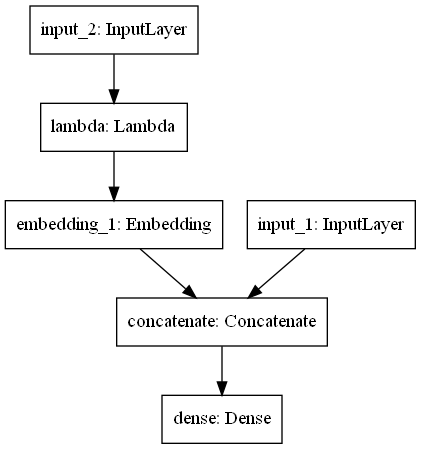

In [31]:
keras.utils.plot_model(model)